<a href="https://colab.research.google.com/github/thekaranacharya/DeepLearning-Temperature-Prediction/blob/master/daily_min_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Daily Min. Temperatures in Melbourne, Australia using Convolutional and Recurrent Neural Networks

Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Conv1D, Lambda, LSTM, Bidirectional, SimpleRNN, Dense
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import mean_absolute_error

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import csv

tf.__version__

'2.3.0'

Downloading the data

In [2]:
dataset_url = "https://github.com/jbrownlee/Datasets/raw/master/daily-min-temperatures.csv"
dataset = os.path.join(os.getcwd(), "daily-min-temps.csv")
tf.keras.utils.get_file(dataset, origin=dataset_url)

73728/67921 [================================] - 0s 0us/step


'/content/daily-min-temps.csv'

Reading it into the desired format

In [3]:
indices =  []
temps = []
with open(dataset, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # skip the column headers
    id = 0
    for row in reader:
        id += 1
        indices.append(id)
        temps.append(float(row[1]))

print(id)
print("\n", temps)

3650

 [20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4, 21.8, 20.0, 16.2, 13.3, 16.7, 21.5, 25.0, 20.7, 20.6, 24.8, 17.7, 15.5, 18.2, 12.1, 14.4, 16.0, 16.5, 18.7, 19.4, 17.2, 15.5, 15.1, 15.4, 15.3, 18.8, 21.9, 19.9, 16.6, 16.8, 14.6, 17.1, 25.0, 15.0, 13.7, 13.9, 18.3, 22.0, 22.1, 21.2, 18.4, 16.6, 16.1, 15.7, 16.6, 16.5, 14.4, 14.4, 18.5, 16.9, 17.5, 21.2, 17.8, 18.6, 17.0, 16.0, 13.3, 14.3, 11.4, 16.3, 16.1, 11.8, 12.2, 14.7, 11.8, 11.3, 10.6, 11.7, 14.2, 11.2, 16.9, 16.7, 8.1, 8.0, 8.8, 13.4, 10.9, 13.4, 11.0, 15.0, 15.7, 14.5, 15.8, 16.7, 16.8, 17.5, 17.1, 18.1, 16.6, 10.0, 14.9, 15.9, 13.0, 7.6, 11.5, 13.5, 13.0, 13.3, 12.1, 12.4, 13.2, 13.8, 10.6, 9.0, 10.0, 9.8, 11.5, 8.9, 7.4, 9.9, 9.3, 9.9, 7.4, 8.6, 11.9, 14.0, 8.6, 10.0, 13.5, 12.0, 10.5, 10.7, 8.1, 10.1, 10.6, 5.3, 6.6, 8.5, 11.2, 9.8, 5.9, 3.2, 2.1, 3.4, 5.4, 9.6, 11.5, 12.3, 12.6, 11.0, 11.2, 11.4, 11.8, 12.8, 11.6, 10.6, 9.8, 11.2, 5.7, 7.1, 2.5, 3.5, 4.6, 11.0, 5.7, 7.7, 10.4, 11.4, 9.2, 6.1, 2.7, 4.3, 6.3, 3.8, 4.4, 

Conversion to NumPy arrays and defining the helper function to plot graphs

In [4]:
# Convert to numpy arrays
steps = np.array(indices)
temps = np.array(temps)

def plot_series(x, y, name, color=None):
    if not color:
        plt.plot(x, y)
    else:
        plt.plot(x, y, color)
    plt.title(name)
    plt.xlabel("Time Steps")
    plt.ylabel("Melbourne Daily Min. Temperature")


Plot of the whole dataset

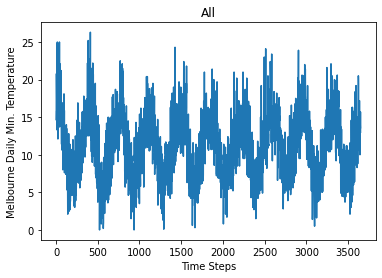

In [5]:
plot_series(steps, temps, "All")

split_time = 2500
train_steps = steps[: split_time]
train_temps = temps[: split_time]

val_steps = steps[split_time:]
val_temps = temps[split_time:]


Training set (Upto 2500 steps out of total 3500)

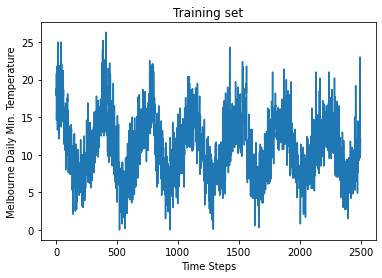

In [6]:
plot_series(train_steps, train_temps, "Training set")


Validation Set

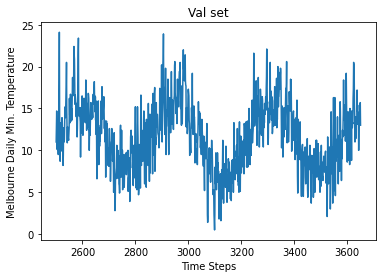

In [7]:

plot_series(val_steps, val_temps, "Val set")

Helper functions to window the datasets & get forecasts

In [8]:

def get_windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda win: win.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer_size)\
        .map(lambda win: (win[: -1], win[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

def get_forecast(model, series, window_size, batch_size, shuffle_buffer_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda win: win.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Defining the model and the LearningRateScheduler to dynamically adjust learning rate

In [17]:
WINDOW_SIZE = 60
BATCH_SIZE = 128
BUFFER_SIZE = 1000

ds = get_windowed_dataset(train_temps, WINDOW_SIZE, BATCH_SIZE, BUFFER_SIZE)

model = tf.keras.Sequential([
    Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu', input_shape=[None, 1]),
    LSTM(128, return_sequences=True),
    LSTM(128),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1),
    Lambda(lambda x: x * 25.0)
])

lr_scheduler = LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))

model.compile(loss=Huber(), optimizer=SGD(lr=1e-8, momentum=0.9), metrics=['mae'])
hist = model.fit(ds, epochs=100, callbacks=[lr_scheduler], verbose=2)

Epoch 1/100
20/20 - 1s - loss: 12.6003 - mae: 13.1003
Epoch 2/100
20/20 - 1s - loss: 12.5347 - mae: 13.0347
Epoch 3/100
20/20 - 1s - loss: 12.4492 - mae: 12.9492
Epoch 4/100
20/20 - 1s - loss: 12.3529 - mae: 12.8529
Epoch 5/100
20/20 - 1s - loss: 12.2455 - mae: 12.7455
Epoch 6/100
20/20 - 1s - loss: 12.1259 - mae: 12.6259
Epoch 7/100
20/20 - 1s - loss: 11.9926 - mae: 12.4926
Epoch 8/100
20/20 - 1s - loss: 11.8445 - mae: 12.3444
Epoch 9/100
20/20 - 1s - loss: 11.6800 - mae: 12.1799
Epoch 10/100
20/20 - 1s - loss: 11.4970 - mae: 11.9969
Epoch 11/100
20/20 - 1s - loss: 11.2934 - mae: 11.7931
Epoch 12/100
20/20 - 1s - loss: 11.0680 - mae: 11.5675
Epoch 13/100
20/20 - 1s - loss: 10.8183 - mae: 11.3174
Epoch 14/100
20/20 - 1s - loss: 10.5393 - mae: 11.0381
Epoch 15/100
20/20 - 1s - loss: 10.2306 - mae: 10.7292
Epoch 16/100
20/20 - 1s - loss: 9.8919 - mae: 10.3904
Epoch 17/100
20/20 - 1s - loss: 9.5239 - mae: 10.0225
Epoch 18/100
20/20 - 1s - loss: 9.1249 - mae: 9.6233
Epoch 19/100
20/20 - 1s

Plot of the Learning Rate with the epochs

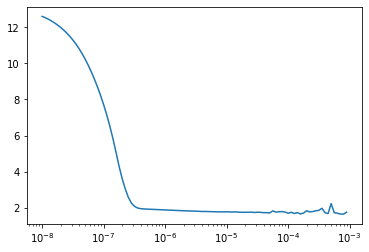

In [18]:
plt.semilogx(hist.history['lr'], hist.history['loss'])

Selecting the best learning rate ~ 3e-5 and fitting again

In [19]:
model.compile(loss=Huber(), optimizer=SGD(lr=3e-5, momentum=0.9), metrics=['mae'])
history = model.fit(ds, epochs=300, verbose=2)

Epoch 1/300
20/20 - 1s - loss: 1.6103 - mae: 2.0561
Epoch 2/300
20/20 - 1s - loss: 1.5667 - mae: 2.0086
Epoch 3/300
20/20 - 1s - loss: 1.5525 - mae: 1.9937
Epoch 4/300
20/20 - 1s - loss: 1.5413 - mae: 1.9832
Epoch 5/300
20/20 - 1s - loss: 1.5471 - mae: 1.9899
Epoch 6/300
20/20 - 1s - loss: 1.5479 - mae: 1.9923
Epoch 7/300
20/20 - 1s - loss: 1.5352 - mae: 1.9777
Epoch 8/300
20/20 - 1s - loss: 1.5380 - mae: 1.9797
Epoch 9/300
20/20 - 1s - loss: 1.5364 - mae: 1.9788
Epoch 10/300
20/20 - 1s - loss: 1.5327 - mae: 1.9754
Epoch 11/300
20/20 - 1s - loss: 1.5307 - mae: 1.9718
Epoch 12/300
20/20 - 1s - loss: 1.5293 - mae: 1.9712
Epoch 13/300
20/20 - 1s - loss: 1.5280 - mae: 1.9692
Epoch 14/300
20/20 - 1s - loss: 1.5305 - mae: 1.9731
Epoch 15/300
20/20 - 1s - loss: 1.5266 - mae: 1.9681
Epoch 16/300
20/20 - 1s - loss: 1.5356 - mae: 1.9774
Epoch 17/300
20/20 - 1s - loss: 1.5228 - mae: 1.9637
Epoch 18/300
20/20 - 1s - loss: 1.5234 - mae: 1.9649
Epoch 19/300
20/20 - 1s - loss: 1.5251 - mae: 1.9669
Ep

Getting the forecasts

In [20]:
forecast = get_forecast(model, temps[..., np.newaxis], WINDOW_SIZE, BATCH_SIZE, BUFFER_SIZE)
forecast

array([[16.489946],
       [17.085556],
       [16.672647],
       ...,
       [13.807832],
       [14.932278],
       [13.475314]], dtype=float32)

Getting the result (Forecasts only on the validation set)

In [21]:
result = forecast[split_time - WINDOW_SIZE: -1, 0]
result

array([12.172177, 11.398072, 12.411488, ..., 13.64723 , 13.807832,
       14.932278], dtype=float32)

Plot of the actual validation set values alongwith the predicted

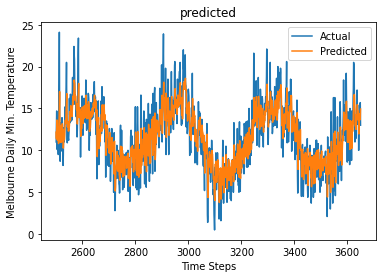

In [22]:
plot_series(val_steps, val_temps,"val")
plot_series(val_steps, result, "predicted")
plt.legend(['Actual', 'Predicted'])


Mean Absolute Error

In [23]:
mean_absolute_error(val_temps, result).numpy()


1.7876

Wow, this is an amazing MAE and the model's prediction is very close as evident from the plot!

Plotting the Huber Loss v MAE

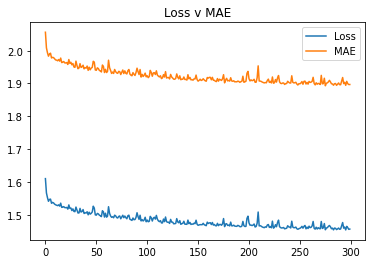

In [25]:
loss = history.history['loss']
mae = history.history['mae']

epochs = range(300)
plt.plot(epochs, loss)
plt.plot(epochs, mae)
plt.title('Loss v MAE')
plt.legend(['Loss', 'MAE'])


As we can see some instablility in the late rpart, let's zoom in a bit to check whether it's not a big noise

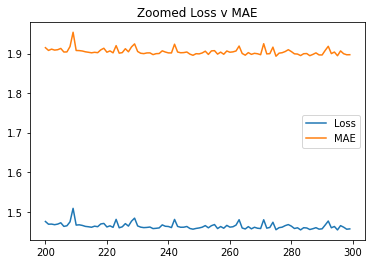

In [26]:
epochs_zoom = epochs[-100:]
zoom_loss = loss[-100:]
zoom_mae = mae[-100:]
plt.plot(epochs_zoom, zoom_loss)
plt.plot(epochs_zoom, zoom_mae)
plt.title('Zoomed Loss v MAE')
plt.legend(['Loss', 'MAE'])

It's actually quite stable. This is a good sign.

**In this way, using a combination of Keras Conv1D, LSTM, and Dense layers, a very good prediction of daily min. temperatures has been achieved!**